# **Excercise session 5: Temperature time series forecasting**

In this notebook you will work on time series analysis and forecasting, focusing on temperature registers from the Finnish Meteorological Institute's observation stations. There are several weather stations across Finland, you are asked to choose one, collect historical temperature data and perform a detailed time series analysis. After that you will develop two models for forecasting temperature time series: a baseline model and another employing the advanced Prophet model. You will then explore the urban heat island effect by comparing temperature data from urban and rural observation stations.

This exercise is designed to be completed on Aalto JupyterHub. Please ensure that your notebook includes all necessary installation commands for any additional libraries your code requires. These commands should be clearly written and integrated within your notebook. To submit, go to Nbgrader/Assignment List and click submit next to the exercise. 
All data loaded from Copernicus Dataspace, should be saved to /coursedata/users/$USER folder.

The deadline is Feb 22 at 10:00. We will be grading the submissions as they arrive, so if you submit before the deadline, you will most likely get feedback earlier.

In [2]:
# Import necessary modules. If any additional modules need to be installed to run it on Aalto JupyterHub, 
# include all necessary installation commands.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## **Exercise 5.1: Data preparation and exploration** (2 pt)

In this excercise you will analyze historical temperature data from a weather observation station in Finland to understand its temperature patterns, variability and trends. Data can be obtained from the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/download-observations).
Choose one weather station located inside a city. Choose hourly observations of average temperature for the period 2014 to 2023.

1. **Data loading:** Load the data into a Pandas DataFrame and parse the dates so you end up with two columns: `timestamp`, datetime object of the form `yyyy-mm-dd hh:mm:ss` (as DataFrame index column), and `y`, the average hourly temperature.
2. **Data check-up:** check for missing values in the dataset. Depending on the extent and nature of the missing data, you might choose to fill in missing values using methods like forward fill, backward fill, or interpolation. Alternatively, if the missing data is extensive or not randomly distributed, you might opt to remove those observations.
5. **Initial exploration:** Plot the entire temperature time series to visualize any noticeable irregularities. Compute statistical summaries to understand the distribution and central tendencies of the temperature data. Justify your choices. Explain in your own words any obvious patterns, trends or anomalies that you see.

In [14]:
file_path = '/coursedata/users/nguyenb5/assignment5/Helsinki Kumpula 1.1.2014 - 31.12.2023.csv'
df = pd.read_csv(file_path)
print(len(df))
df.head()

82296


Observation station  Year  Month  Day Time [Local time]  \
0    Helsinki Kumpula  2014      1    1             00:00   
1    Helsinki Kumpula  2014      1    1             01:00   
2    Helsinki Kumpula  2014      1    1             02:00   
3    Helsinki Kumpula  2014      1    1             03:00   
4    Helsinki Kumpula  2014      1    1             04:00   

   Average temperature [°C]  
0                       4.4  
1                       4.5  
2                       4.8  
3                       4.8  
4                       4.7

In [15]:
df['timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg(' '.join, axis=1), 
                                 format='%Y %m %d %H:%M')

# Set 'timestamp' as the index and keep 'Average temperature [°C]' as the 'y' column
df = df.set_index('timestamp')[['Average temperature [°C]']].rename(columns={'Average temperature [°C]': 'y'})
df.index = pd.DatetimeIndex(df.index)
full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df[~df.index.duplicated(keep='first')]
df_complete = df.reindex(full_time_index)

df_complete.head()

y
2014-01-01 00:00:00  4.4
2014-01-01 01:00:00  4.5
2014-01-01 02:00:00  4.8
2014-01-01 03:00:00  4.8
2014-01-01 04:00:00  4.7

We can see that there are some hours whoes values are missing. We can try to interpolate the time series using default pandas methods. This can avoid much troubles later during distancing processes of time series. 

In [16]:
df_complete.isnull().values.any()

True

In [17]:
df_inter = df_complete.interpolate(method='linear')
print(df_inter.isnull().values.any())
df_inter.head()

False


y
2014-01-01 00:00:00  4.4
2014-01-01 01:00:00  4.5
2014-01-01 02:00:00  4.8
2014-01-01 03:00:00  4.8
2014-01-01 04:00:00  4.7

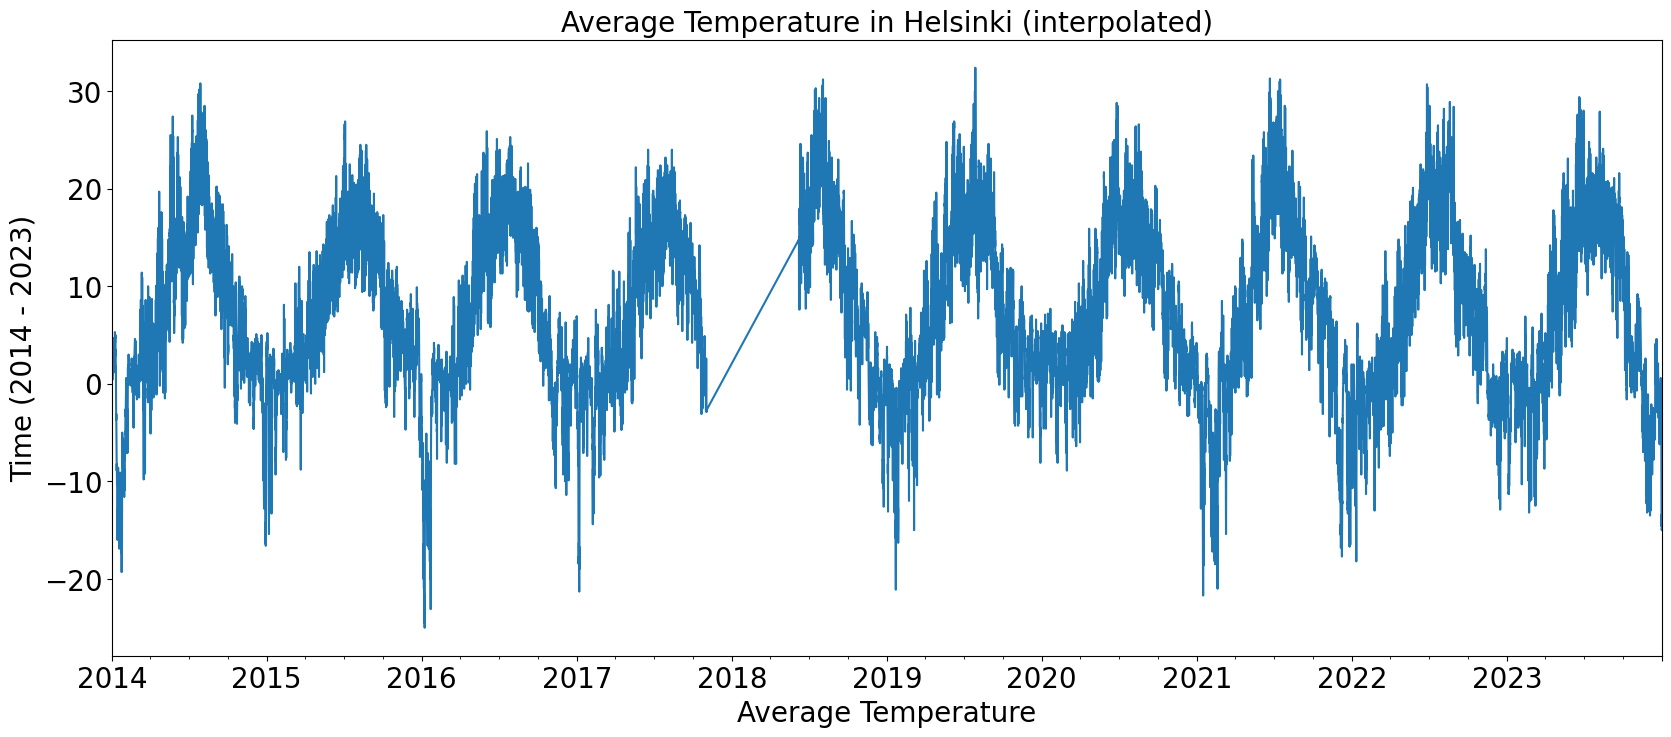

In [18]:
### First, we need to visualize the data

df_inter.y.plot(figsize=(20, 8))
plt.xlabel('Average Temperature',fontsize=20)
plt.ylabel('Time (2014 - 2023)',fontsize=20)
plt.title('Average Temperature in Helsinki (interpolated)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

We can see that the missing data is very large, so no interpolation methods can fit inside easily. 
Therefore, I decided to simply accept linear interpolation for this time series and accept this large gap of around 6 months

## **Exercise 5.2: Time series analysis** (2 pt)

In this exercise you will perform a detailed time series analysis to analyze trends, seasonality, and anomalies in the data. 

1. **Time series decomposition:** The first step is to decompose the time series to observe trends, seasonality and residuals. Analyze the decomposed components and note observations about the trend, seasonal patterns, and residuals. The choice of the seasonality period depends on the specific seasonal effect you want to examine:
   - For daily cycles (day-night variation), use 24.
   - For annual cycles (seasonal changes over the year), use 8760 (= 24$\cdot$365)
2. **Seasonality analysis:** Focus on the seasonal component to identify specific seasonal patterns (daily, monthly, or yearly seasonality).
3. **Trend analysis:** Apply a rolling mean with an appropriate window size to analyze long-term trends in temperature. Discuss any increasing or decreasing trends observed.
4. **Anomaly detection:** identify and investigate anomalies or outliers in the data, such as unseasonably hot or cold days, and hypothessize potential causes (e.g. heatwaves, cold fronts).


**Note:** `statsmodels` library can be useful here. Check [this](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis).

You can take a look at [this notebook](https://www.kaggle.com/code/davidandressanchez/seasonal-decomposition) on seasonal decomposition for inspiration.

### 1. **Time series decomposition:** 

#### Daily cycle

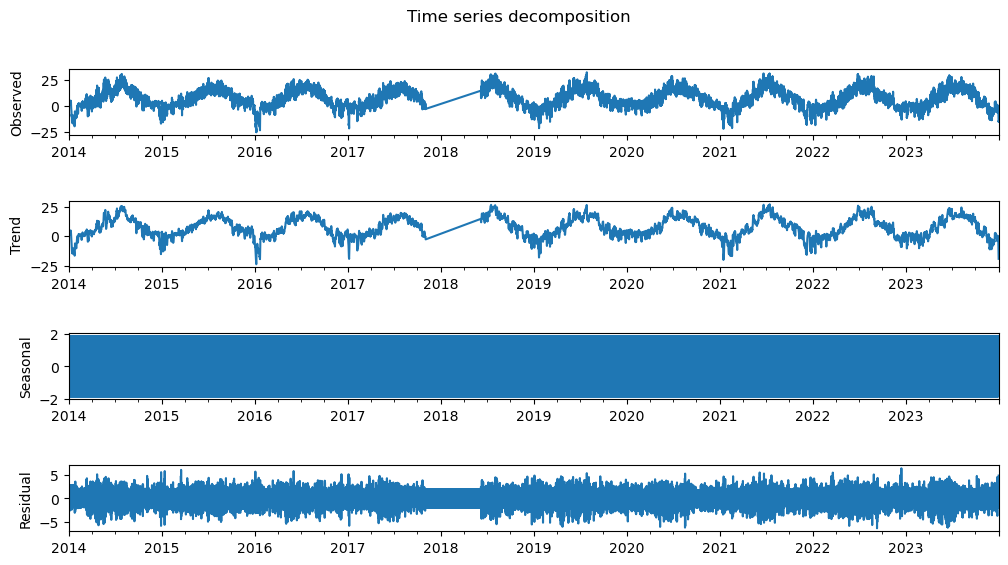

In [7]:
decomposition = seasonal_decompose(df_inter, model='additive', period=24, extrapolate_trend='freq')

fig, axs = plt.subplots(4, figsize=(12, 6))
fig.suptitle('Time series decomposition')
decomposition.observed.plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_ylabel('Observed')
axs[1].set_ylabel('Trend')
axs[2].set_ylabel('Seasonal')
axs[3].set_ylabel('Residual')
plt.subplots_adjust( hspace=1 )

How to interpret this figure above?

- Observed: This is the original time series data we are working with. It shows the raw data points without any modification or filtering. 

- Trend: This graph shows the long-term progression of the data, removing seasonal effects and other irregularities. It's a smoothed version of the observed data that tells whether the data is increasing, decreasing, or staying stable over time. On a daily cycle, we can see that there is a clear trend, as the trend data has a cycle. This is probably due to temperature fluctuating throughout the day, from coldest in midnight to warmest in the noon. 

- Seasonal: This component shows the repeatable pattern within the time series data for a fixed period, which we have chosen as 24 days to represent daily seasonality. If there are clear regular patterns, this indicates strong seasonal behavior. However, there is no pattern at all, suggesting ona daily basis, there is no seasonal trend

- Residual: The residuals represent the noise left after the trend and seasonal components are removed from the observed data. Ideally, this should resemble white noise, meaning it should be randomly distributed with zero mean

We should verify that the residuals are white noise (whose requirements coincide with those of stationarity).

We can use the Augmented Dickey-Fuller Test for that in the same way as we use it to check stationarity.

In [9]:
adf_test = adfuller(decomposition.resid)
print(f"p-value = {adf_test[1]}")

p-value = 0.0


The resulting p-value is 0.0, which is lower than our significance level (0.05).

Therefore, we can reject the null hypothesis (H₀: time series is non-stationary), which for us means that our time series can be considered white noise on the daily cycle

#### Monthly cycle

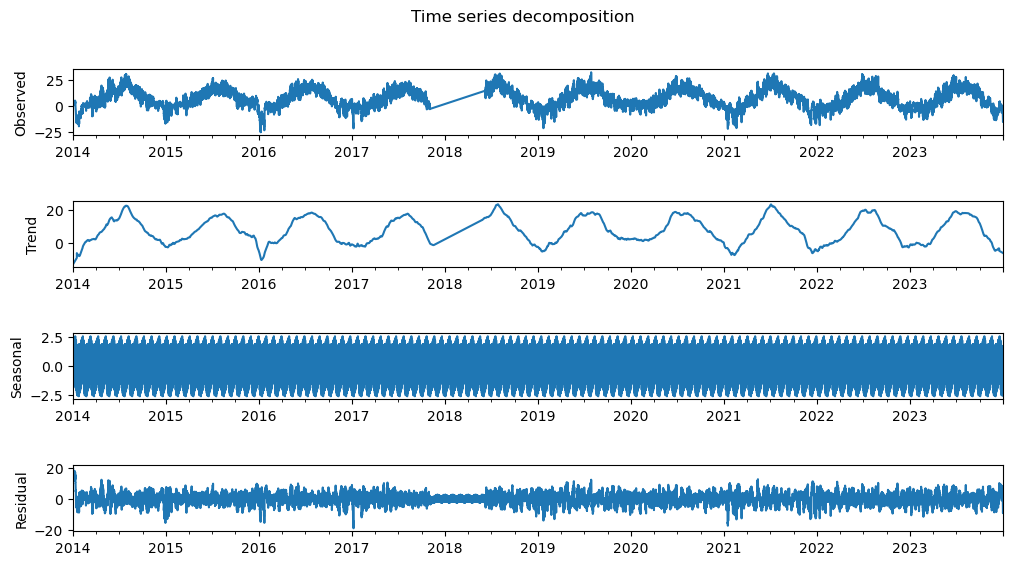

In [10]:
decomposition = seasonal_decompose(df_inter, model='additive', period=720, extrapolate_trend='freq')

fig, axs = plt.subplots(4, figsize=(12, 6))
fig.suptitle('Time series decomposition')
decomposition.observed.plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_ylabel('Observed')
axs[1].set_ylabel('Trend')
axs[2].set_ylabel('Seasonal')
axs[3].set_ylabel('Residual')
plt.subplots_adjust( hspace=1 )

- Trend: On a monthly cycle, we can see that there is a clear trend, as the trend data has a cycle. This is probably due to temperature fluctuating based on seasons 

- Seasonal: There is no clear pattern, suggesting that on a monthly basis, there is no seasonal trend

We should verify that the residuals are white noise (whose requirements coincide with those of stationarity).

We can use the Augmented Dickey-Fuller Test for that in the same way as we use it to check stationarity.

In [24]:
adf_test = adfuller(decomposition.resid)
print(f"p-value = {adf_test[1]}")

p-value = 0.0


The resulting p-value is 0.0, which is lower than our significance level (0.05).

Therefore, we can reject the null hypothesis (H₀: time series is non-stationary), which for us means that our time series can be considered white noise on the monthly cycle

#### Annual cycle

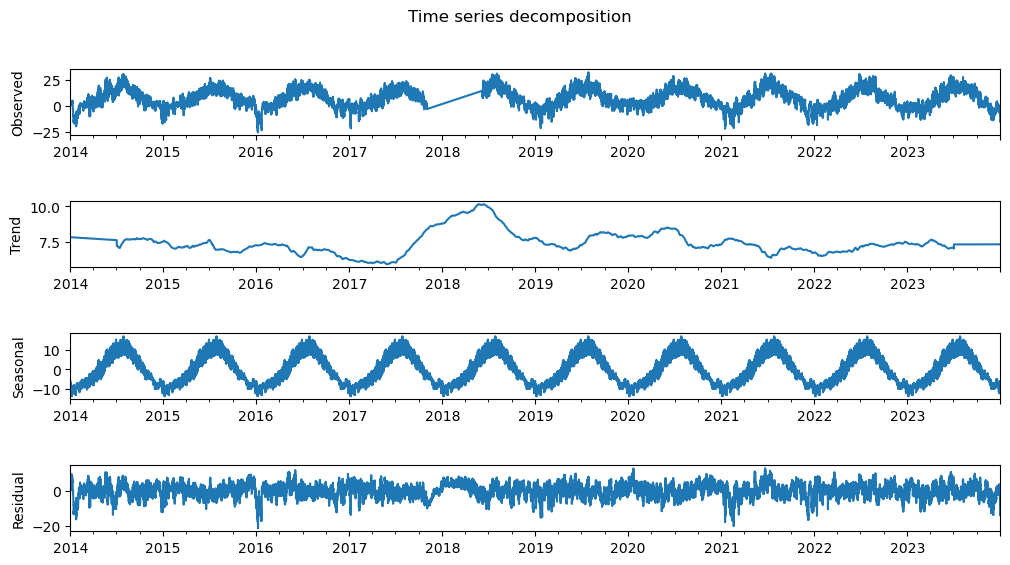

In [25]:
decomposition = seasonal_decompose(df_inter, model='additive', period=8760, extrapolate_trend='freq')

fig, axs = plt.subplots(4, figsize=(12, 6))
fig.suptitle('Time series decomposition')
decomposition.observed.plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_ylabel('Observed')
axs[1].set_ylabel('Trend')
axs[2].set_ylabel('Seasonal')
axs[3].set_ylabel('Residual')
plt.subplots_adjust( hspace=1 )

- Trend: On a annual cycle, we can see that there is no trend at all, as the trend data looks very flat. We should not be tricked by a line between 2017-2019, as our original time series lack these data.  

- Seasonal: There is a clear pattern, suggesting on an annual basis, there is a seasonal trend, from cold temperature in the winter to hot temperature in the summer

We should verify that the residuals are white noise (whose requirements coincide with those of stationarity).

We can use the Augmented Dickey-Fuller Test for that in the same way as we use it to check stationarity.

In [55]:
adf_test = adfuller(decomposition.resid)
print(f"p-value = {adf_test[1]}")

p-value = 6.682666365822234e-10


The resulting p-value is very close to 0.0, which is lower than our significance level (0.05).

Therefore, we can reject the null hypothesis (H₀: time series is non-stationary), which for us means that our time series can be considered white noise on the annual cycle

### 2. **Seasonality analysis:**

Analysis have been conducted above

In [26]:
# For daily cycles
decomposition_daily = seasonal_decompose(df_inter, model='additive', period=24)
# For monthly cycles
decomposition_monthly = seasonal_decompose(df_inter, model='additive', period=30*24)
# For annual cycles
decomposition_annually = seasonal_decompose(df_inter, model='additive', period=365*24)

### 3. **Trend analysis:**

Apply a rolling mean with an appropriate window size to analyze long-term trends in temperature. Discuss any increasing or decreasing trends observed.

<Axes: title={'center': 'Rolling Mean Temperature Trend'}>

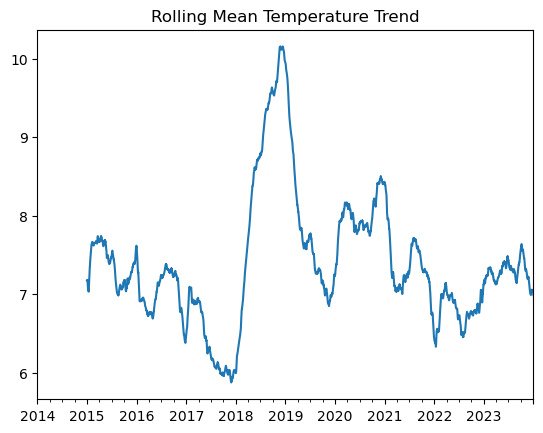

In [19]:
rolling_window_size = 24*365
df_inter['rolling_mean'] = df_inter['y'].rolling(window=rolling_window_size).mean()
df_inter['rolling_mean'].plot(title='Rolling Mean Temperature Trend')

A rolling mean (moving average) is the averages of different subsets of the complete dataset. For each subsequent point, the subset of data used for calculating the mean is shifted forward. This technique is useful in smoothing out fluctuations in a seasonal time series and show long term trend.

We can safely ifnore the 2018 to 2019 as it is missing values. However, we can clearly see that the rolling mean of 2015-2018 is on average lower than the rolling mean of 2019-2023, suggesting that the average temperature has risen to around 0.2 Celcius

### 4. **Anomaly detection:**

Identify and investigate anomalies or outliers in the data, such as unseasonably hot or cold days, and hypothesize potential causes (e.g. heatwaves, cold fronts).

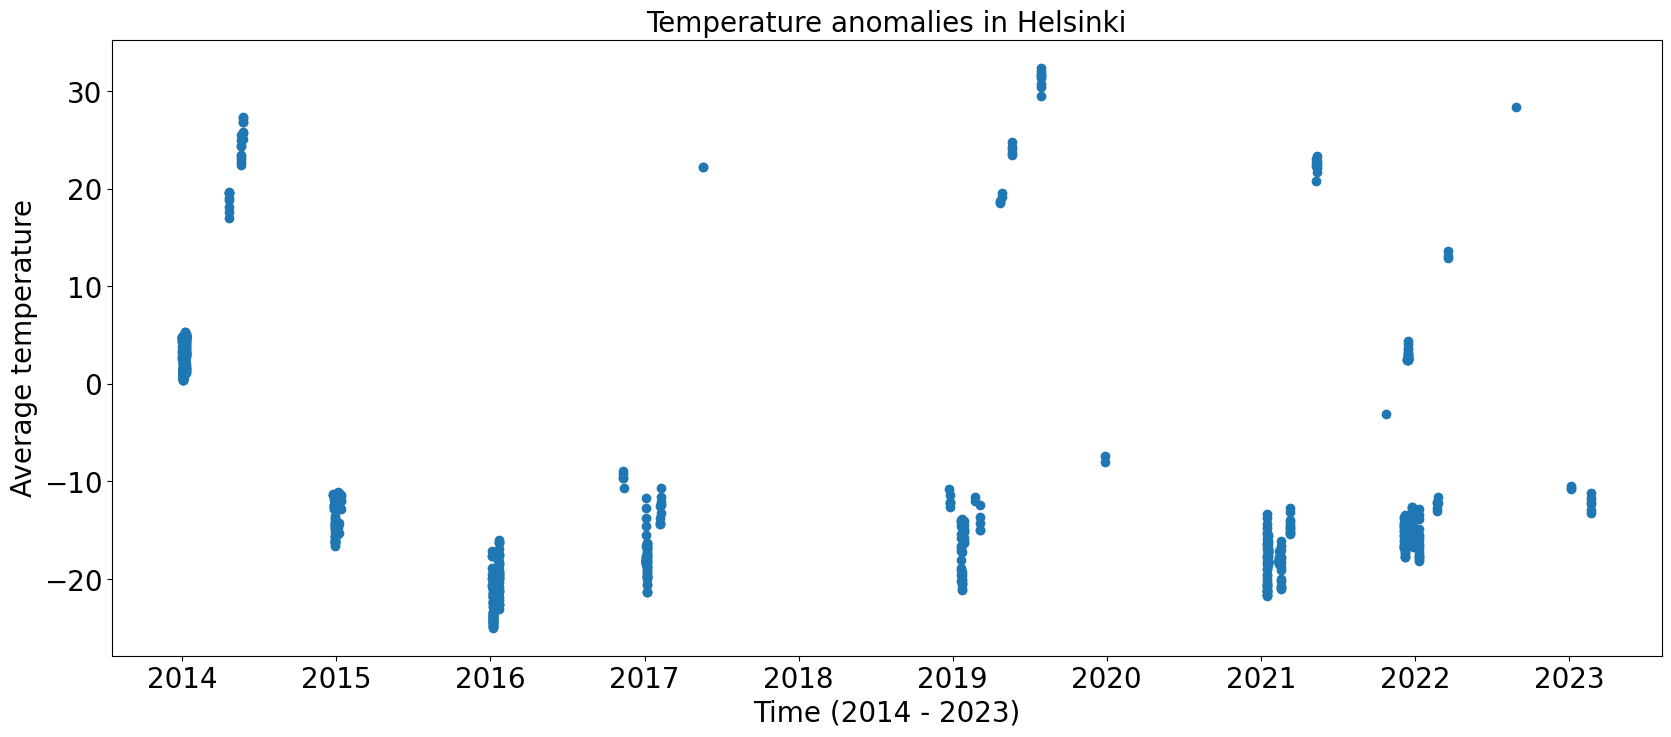

In [24]:
residuals_aligned = decomposition.resid.reindex(df_inter.copy().index)

# std of residuals
std_resid = residuals_aligned.std()

#  mask for anomalies where the abs residual is more than 3 standard deviations from the mean
anomaly_mask = abs(residuals_aligned) > 3 * std_resid

anomalies = df_inter.copy()[anomaly_mask]

plt.figure(figsize=(20, 8)) 
plt.scatter(anomalies.index, anomalies["y"])
plt.xlabel('Time (2014 - 2023)', fontsize=20)
plt.ylabel('Average temperature', fontsize=20)
plt.title('Temperature anomalies in Helsinki', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Hypothesis of potential causes: there are heatwaves in year 2021-2022. On the other hand, A cold front occurs when a mass of comparatively colder air moves into where warmer air is present (wiki).  Helsinki Kumppula may have face a cold front then in 2016 

## **Exercise 5.3: Build a baseline forecasting model** (4 pt)

In this exercise you are asked to create a baseline model to forecast future temperatures based on historical data. This model will serve as a reference model for comparing more complex models like Prophet.

1. **Feature engineering**: Depending on your chosen model, you may want to add features to your DataFrame based on the time of the measurement that help capture the temporal dynamics of the series, such as lagged variables, rolling statistics, or time components (e.g., day of the week, month, year).
2. **Model selection:** Create a baseline model to forecast temperatures from your chosen location. You may choose from traditional statistical methods like AR, MA or SARIMA, or machine learning models like random forest or XGBoost.
3. **Training and test sets:** Divide your dataset into a training set (the first 8 years) and test set (the last 2 years).
4. **Fit and train your model.**
5. **Forecasting:** Use the fitted model to predict future temperatures for the test set period.
6. **Evaluation:** Evaluate your model forecast using mean absolute error (MAE) and root mean squared error (RMSE).
7. **Results:** Visualize your predicted temperatures and compare with the actual temperatures in the test period.
8. **Discussion:** Discuss the performance of your chosen baseline model. Reflect on its strengths and limitations in capturing the underlying patterns of the data. 

1. **Feature engineering**: Depending on your chosen model, you may want to add features to your DataFrame based on the time of the measurement that help capture the temporal dynamics of the series, such as lagged variables, rolling statistics, or time components (e.g., day of the week, month, year).

In [25]:
# Adding time components

df_features = df_inter.copy()

df_features['year'] = df_features.index.year
df_features['month'] = df_features.index.month
df_features['day_of_week'] = df_features.index.dayofweek

# Adding lagged variables
df_features['lag_1'] = df_features['y'].shift(1)
df_features['lag_2'] = df_features['y'].shift(2)

# Adding rolling statistics - window can be adjusted as needed
window = 3
df_features['rolling_mean'] = df_features['y'].rolling(window=window).mean()
df_features['rolling_std'] = df_features['y'].rolling(window=window).std()

df_features.dropna(inplace=True)

df_features.head(10) 

y  rolling_mean  year  month  day_of_week  lag_1  \
2014-01-01 02:00:00  4.8      4.566667  2014      1            2    4.5   
2014-01-01 03:00:00  4.8      4.700000  2014      1            2    4.8   
2014-01-01 04:00:00  4.7      4.766667  2014      1            2    4.8   
2014-01-01 05:00:00  4.7      4.733333  2014      1            2    4.7   
2014-01-01 06:00:00  4.8      4.733333  2014      1            2    4.7   
2014-01-01 07:00:00  4.8      4.766667  2014      1            2    4.8   
2014-01-01 08:00:00  4.6      4.733333  2014      1            2    4.8   
2014-01-01 09:00:00  4.3      4.566667  2014      1            2    4.6   
2014-01-01 10:00:00  3.8      4.233333  2014      1            2    4.3   
2014-01-01 11:00:00  3.4      3.833333  2014      1            2    3.8   

                     lag_2  rolling_std  
2014-01-01 02:00:00    4.4     0.208167  
2014-01-01 03:00:00    4.5     0.173205  
2014-01-01 04:00:00    4.8     0.057735  
2014-01-01 05:00:00    4.8     0.057735  
2014-01-01 06:00:00    4.7     0.057735  
2014-01-01 07:00:00    4.7     0.057735  
2014-01-01 08:00:00    4.8     0.115470  
2014-01-01 09:00:00    4.8     0.251661  
2014-01-01 10:00:00    4.6     0.404145  
2014-01-01 11:00:00    4.3     0.450925

2. **Model selection:** Create a baseline model to forecast temperatures from your chosen location. You may choose from traditional statistical methods like AR, MA or SARIMA, or machine learning models like random forest or XGBoost.

How to choose a model if we know beforehand the time series data?

For stationary data:

- AR (AutoRegressive): Use when we believe that the value of the series at a particular time t is a linear combination of its previous values. The model is good for data where there is a clear trend.

- MA (Moving Average): Use when we believe that the value of the series is a linear combination of the forecast errors of previous time steps. It's suitable for data where the shock impact has a temporary effect. 

- ARMA = AR + MA: Combine both AR and MA models. Use when the time series data shows both AR and MA characteristics. 

For nonstationary data:

- ARIMA = AR + Integrated MA: ARMA that can model data by differencing the data one or more times to remove trends. Use when the data shows non-stationarity and either AR or MA behavior, or both

- SARIMA (Seasonal ARIMA): An extension of ARIMA that adds seasonal differencing, making it capable of modeling both non-stationary data and seasonal data. 

For both stationary and nonstationary data:

- SARIMAX (Seasonal ARIMA with eXogenous variables): An extension of SARIMA that can  model the effects of exogenous variables (variables that are not part of the time series but may have an effect on it, like temperature, holidays, economic indicators, etc.). Use SARIMAX when you have both seasonal data and one or more relevant exogenous variables that we expect to have a influence on the time series.

Model Selection: SARIMAX is a good choice for a baseline model because SARIMAX models are among the most widely used statistical models for forecasting, with excellent forecasting performance. The average temperature data also shows seasonality by annual cycle

3. **Training and test sets:** Training and Test Sets: We'll split df_inter based on the time index so that the first 8 years of data are in the training set and the last 2 years are in the test set.

In [26]:
# Ensure the index is a datetime type
df_features.index = pd.to_datetime(df_features.index)

# Sort the DataFrame by date just in case
df_features.sort_index(inplace=True)

# Split into training and test sets
df_train = df_features[df_features.index.year <= (df_features.index.year.max() - 2)]
df_test = df_features[df_features.index.year > (df_features.index.year.max() - 2)]

print("Number of datapoints in df_train", len(df_train))
print("Number of datapoints in df_test", len(df_test))

Number of datapoints in df_train 70126
Number of datapoints in df_test 17520


4. **Fit and train your model**: Divide your dataset into a training set (the first 8 years) and test set (the last 2 years).

We will use the training set to fit the SARIMA model.

What do the order and seasonal order parameters of SARIMAX mean?

https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

A SARIMA model can be tuned with two kinds of orders:

(p,d,q) order, which refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality);

(P,D,Q,M) seasonal order, which refers to the order of the seasonal component of the time series.

We can determine these parameters based on the ACF and PACF plots (my own notes in Time Series class)

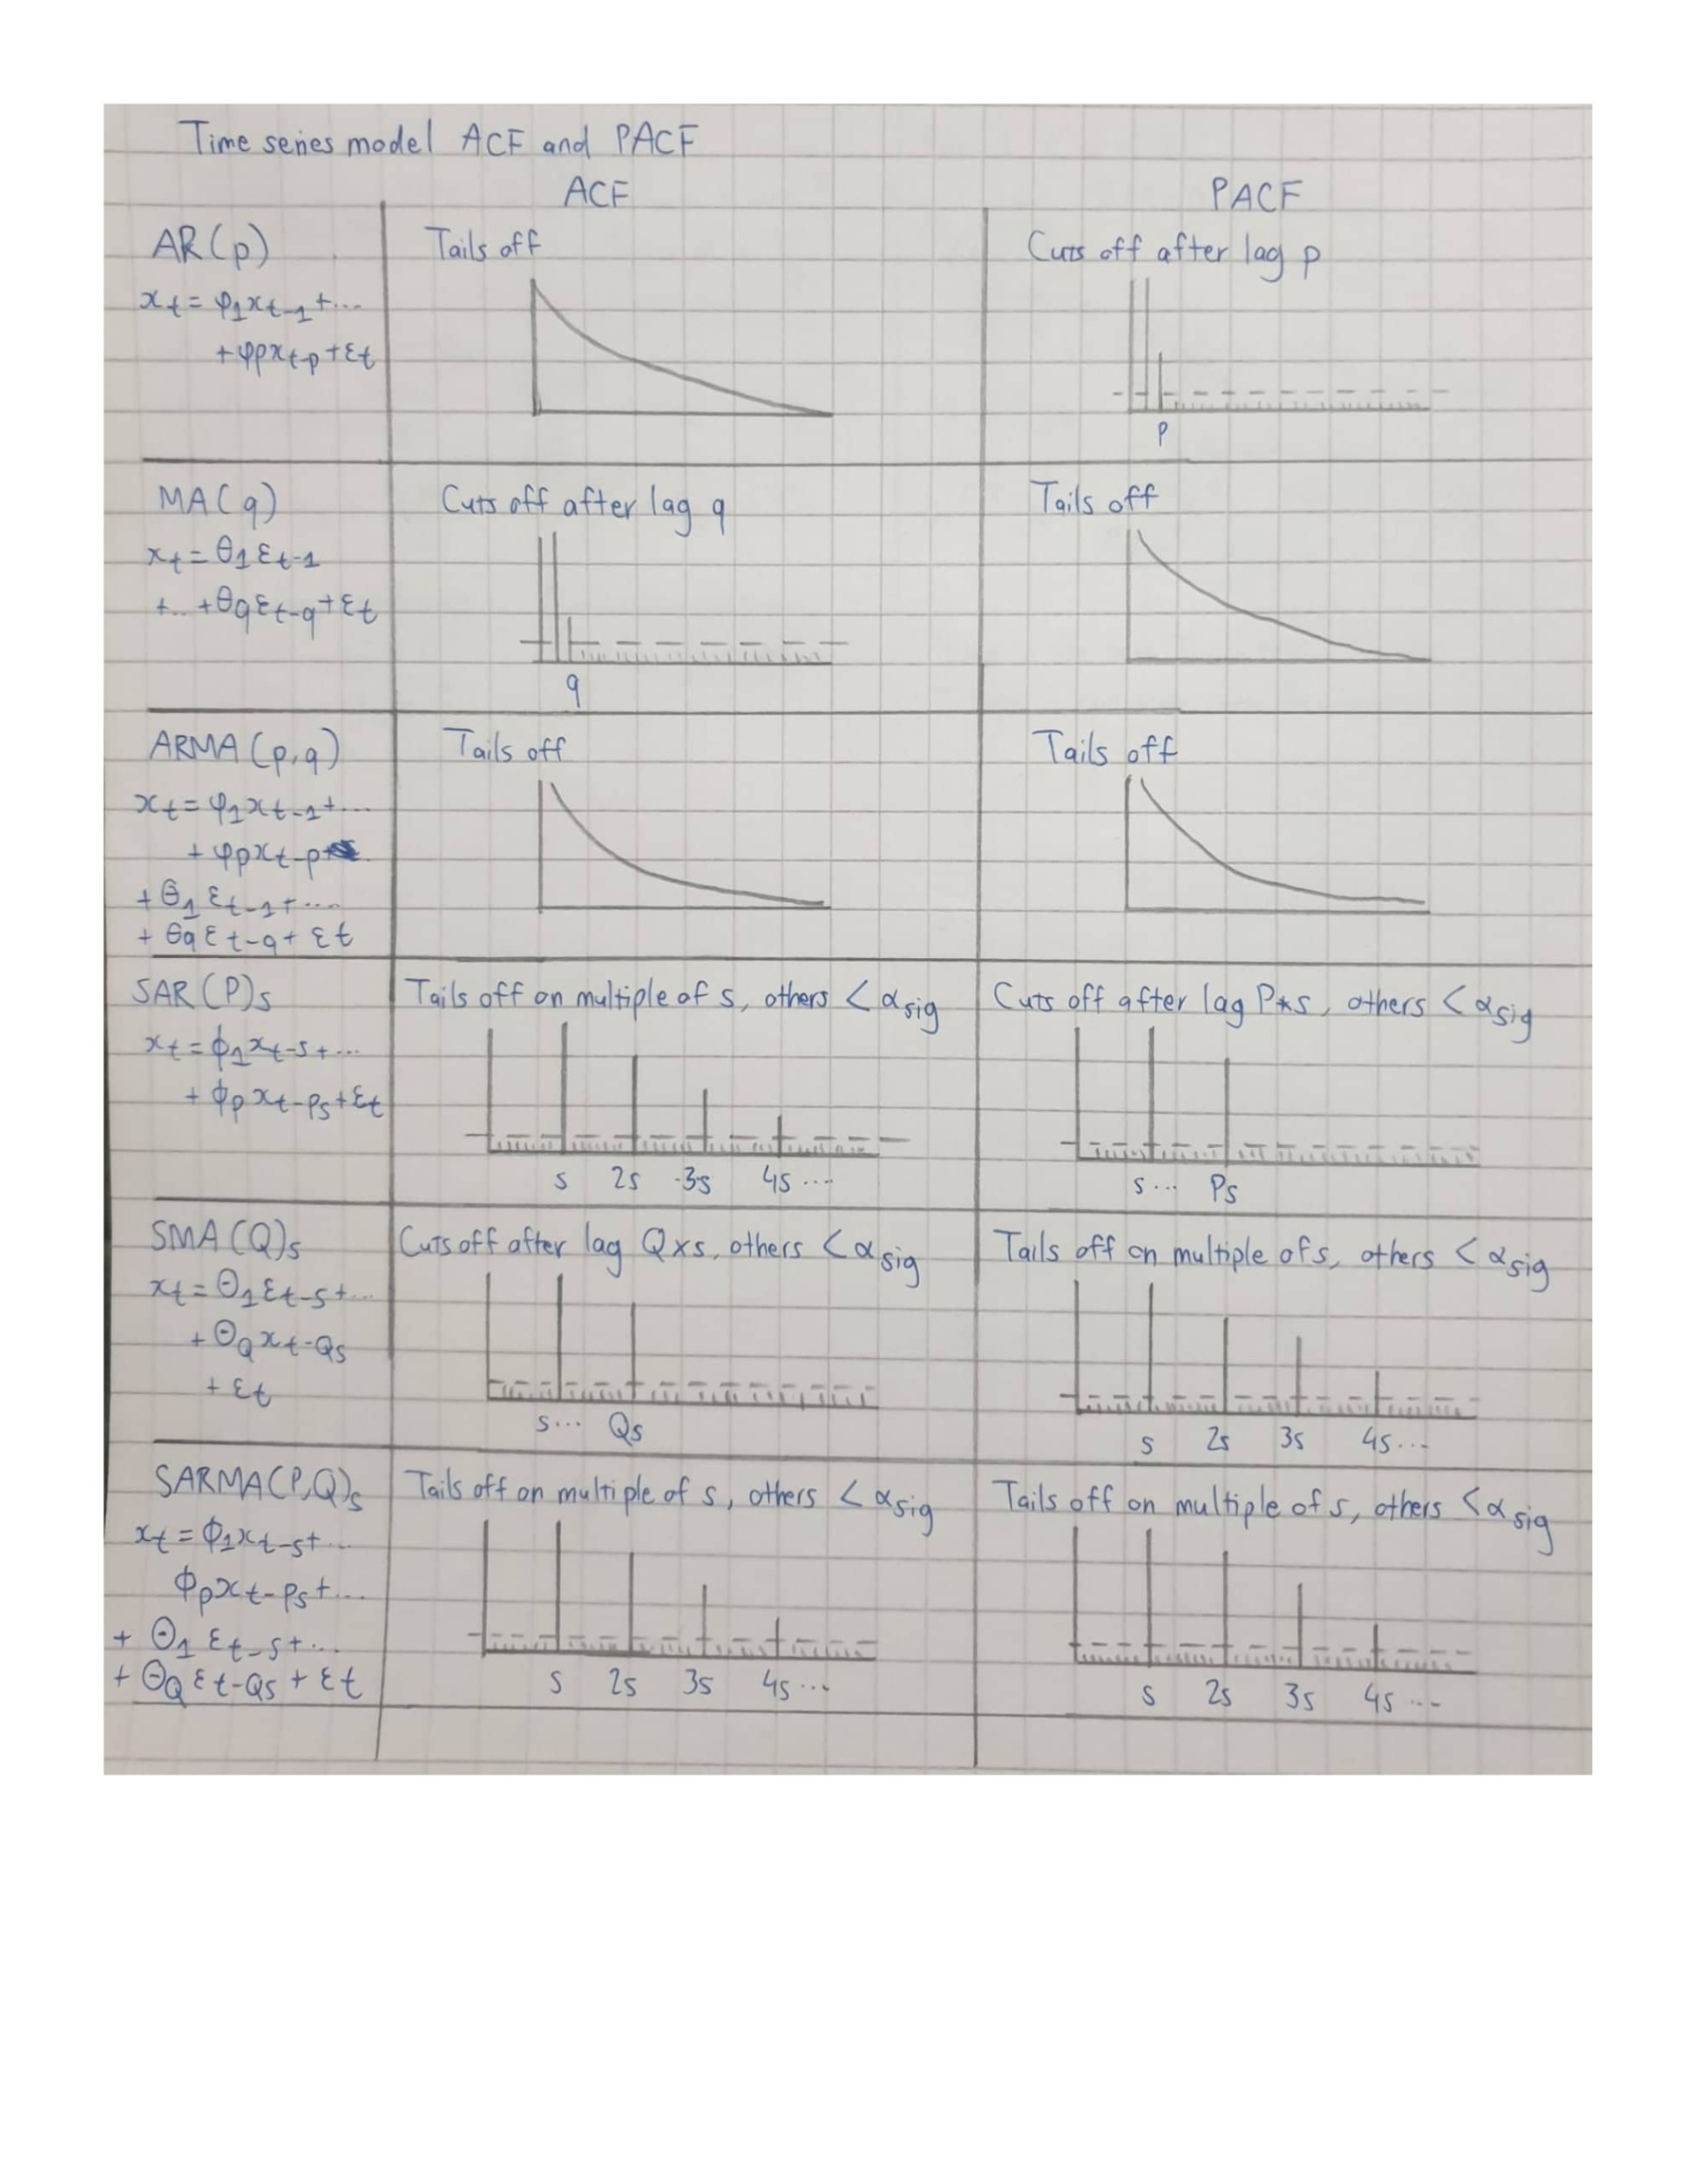

In [14]:
from IPython.display import Image

Image(filename="ACF_PACF.png")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# The parameters (p,d,q) and seasonal parameters (P,D,Q,s) need to be determined based on ACF and PACF plots or grid search

exog_vars = df_train[["rolling_mean", "rolling_std"]]

model = SARIMAX(df_train['y'], 
                exog = exog_vars,
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 24))

# Fit the model
fitted_model = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44630D-01    |proj g|=  7.35168D-01


 This problem is unconstrained.



At iterate    5    f=  3.51725D-01    |proj g|=  8.54397D-01

At iterate   10    f=  3.08134D-01    |proj g|=  9.54388D-02

At iterate   15    f=  3.03734D-01    |proj g|=  4.88308D-03

At iterate   20    f=  3.03706D-01    |proj g|=  5.26755D-04

At iterate   25    f=  3.03705D-01    |proj g|=  3.93223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     33      1     0     0   3.932D-05   3.037D-01
  F =  0.30370508503229532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


We can observe that training with SARIMAX is extremely slow and makes the kernel die due to running out of memory. Therefore, we can apply distancing until the temperature becomes stationary, and then we can use the simpler model for stationary series, AR and MA

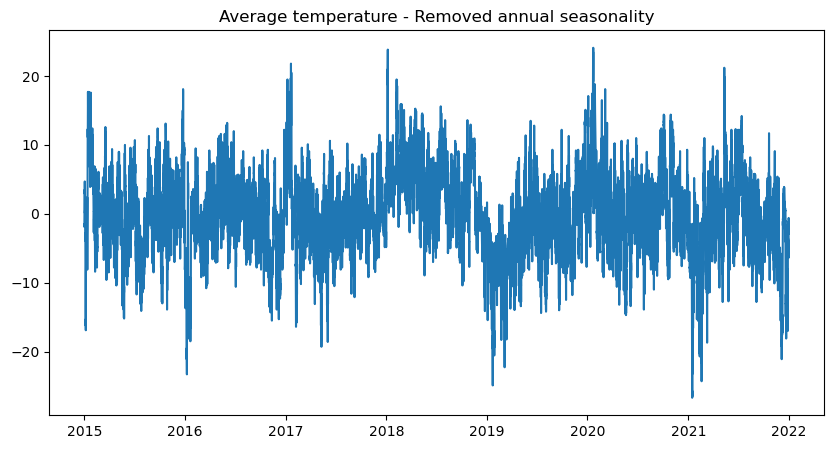

ADF Statistic: -13.757568
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The series is stationary.


In [115]:
from statsmodels.tsa.stattools import adfuller

y = df_train['y']

# First Difference to remove increasing or decreasing trend in temperature
#y_diff = y.diff().dropna()

#plt.figure(figsize=(10, 5))
#plt.plot(df_train.index[1:], y_diff)
#plt.title("Average temperature - Removed increasing/decreasing trend")
#plt.show()

# Seasonal Difference to remove yearly seasonality
seasonal_diff_period = 24 * 365
y_seasonal_diff = y.diff(seasonal_diff_period).dropna()

plt.figure(figsize=(10, 5))
plt.plot(df_train.index[24*365:], y_seasonal_diff)
plt.title("Average temperature - Removed annual seasonality")
plt.show()


# Augmented Dickey-Fuller test on the seasonally differenced data
adf_test_result = adfuller(y_seasonal_diff)

print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
print('Critical Values:')
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Consider additional differencing.")

Now we need to plot the ACF and PACF plots on the distanced time series above to determine the order of AR and MA (if any)

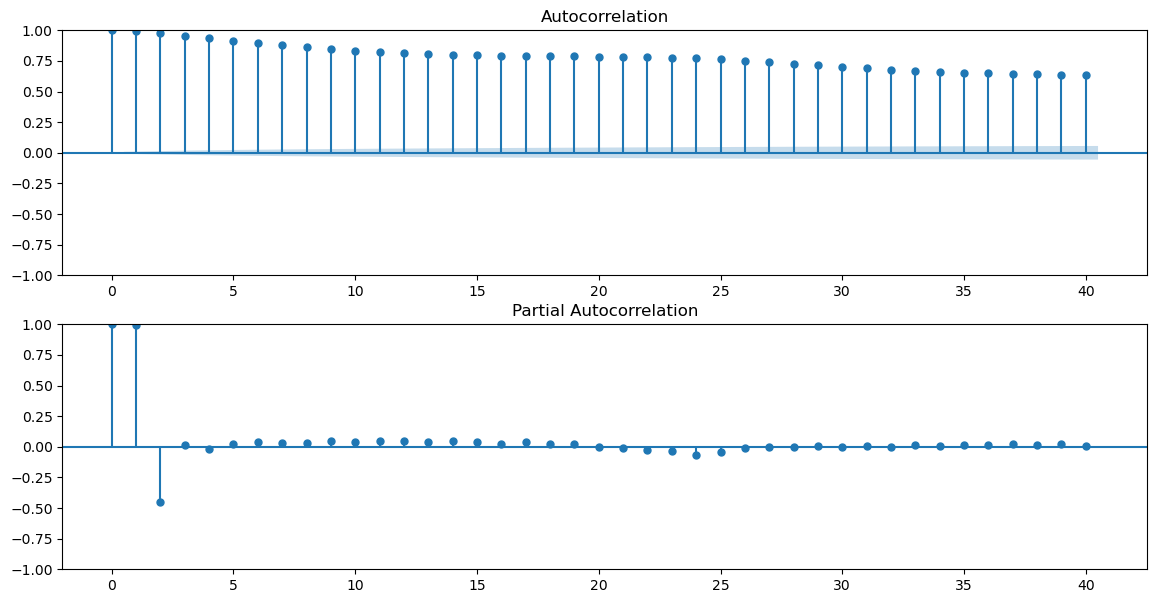

In [116]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Function (ACF)
plt.figure(figsize=(14, 7))
plt.subplot(211)
plot_acf(y_seasonal_diff, ax=plt.gca(), lags=40)

# Partial Autocorrelation Function (PACF)
plt.subplot(212)
plot_pacf(y_seasonal_diff, ax=plt.gca(), lags=40)

# plt.tight_layout()
plt.show()

We can see that there are significant spikes until lag 2 in the PACF and at lag 1 in PACF plots and tails off in the ACF, suggesting that this is AR(2) model.

In [133]:
from statsmodels.tsa.arima.model import ARIMA

# df_train.index[24*365:] is the adjusted index after differencing

# Fit an ARMA model to the stationary time series

# Adding year wont make the model converge

# exog_vars = df_train[["rolling_mean", "rolling_std", "month", "day_of_week", "lag_1", "lag_2"]][1+24*365:]
exog_vars = df_train[["rolling_mean", "lag_1", "lag_2"]][24*365:]
arma_model = ARIMA(y_seasonal_diff,
                   exog=exog_vars,
                   order=(2, 0, 0))
arma_result = arma_model.fit()

# Summary of the model
arma_summary = arma_result.summary()
print(arma_summary)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                61366
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -46865.671
Date:                Fri, 16 Feb 2024   AIC                          93745.342
Time:                        19:46:41   BIC                          93808.514
Sample:                    01-01-2015   HQIC                         93764.943
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7176      0.274    -17.208      0.000      -5.255      -4.180
rolling_mean     2.5281      0.009    269.062      0.000       2.510       2.546
lag_1           -0.9795      0.005   -217.32

5. **Forecasting:** : Use the fitted model to predict future temperatures for the test set period.

Once the model is trained, we'll use it to predict the temperature for the test set period.

In [134]:
exog_forecast = df_test[["rolling_mean", "lag_1", "lag_2"]]

# Make the forecast
n_forecasts = len(df_test) 
forecast = arma_result.get_forecast(steps=n_forecasts, exog=exog_forecast)

# Extract forecast values
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

Text(0, 0.5, 'Average temperature')

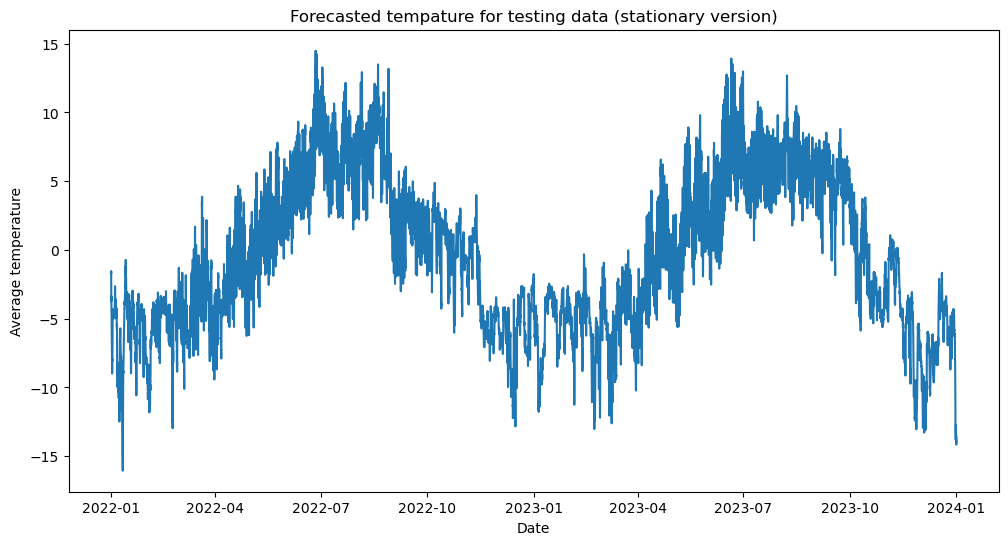

In [135]:
plt.figure(figsize=(12,6))
plt.plot(forecast_values)
plt.title("Forecasted tempature for testing data (stationary version)")
plt.xlabel("Date")
plt.ylabel("Average temperature")

We can see that the forecast is clearly divided into two distinct blocks, which stands for the two years in the testing data. It is also stationary, suggesting that the prediction is working as expected. Now we need to converted this back to the original scale before trend distancing and seasonal distancing

In [136]:
forecast_values_series = pd.Series(forecast_values, index=df_test.index)
seasonally_adjusted_forecast = pd.Series(index=forecast_values_series.index, dtype=float)

for i in range(len(forecast_values_series)):
    # Find the corresponding index in the training set - this accounts for the seasonal lag
    corresponding_index = -(24*365) + i
    if corresponding_index < 0:
        # If within the bounds of the training data, add the last season's observation
        last_seasonal_observation = df_train['y'].iloc[corresponding_index]
        # last_seasonal_observation = y_seasonal_diff.iloc[corresponding_index]
        seasonally_adjusted_forecast.iloc[i] = forecast_values_series.iloc[i] + last_seasonal_observation
    else:
        # If beyond the training data, use the seasonally adjusted forecast itself for addition
        # This part assumes the forecast extends beyond a single seasonal cycle and uses the previously adjusted forecasts
        last_seasonal_observation = seasonally_adjusted_forecast.iloc[i - (24*365)]
        seasonally_adjusted_forecast.iloc[i] = forecast_values_series.iloc[i] + last_seasonal_observation

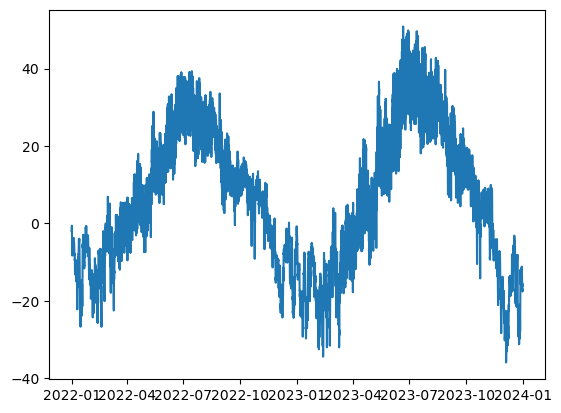

In [137]:
plt.plot(seasonally_adjusted_forecast)

6. **Evaluation:**: Evaluate your model forecast using mean absolute error (MAE) and root mean squared error (RMSE).

We'll calculate the MAE and RMSE between the predicted temperatures and the actual temperatures in the test set.

In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_test['y'], seasonally_adjusted_forecast)
rmse = np.sqrt(mean_squared_error(df_test['y'], seasonally_adjusted_forecast))

print(f"MAE of forecasted temperature: {round(mae, 3)}")
print(f"RMSE of forecasted temperature: {round(rmse, 3)}")

MAE of forecasted temperature: 8.014
RMSE of forecasted temperature: 10.29


7. **Results:**: Visualize your predicted temperatures and compare with the actual temperatures in the test period.

We'll plot the predicted temperatures against the actual temperatures to visualize the model's performance.

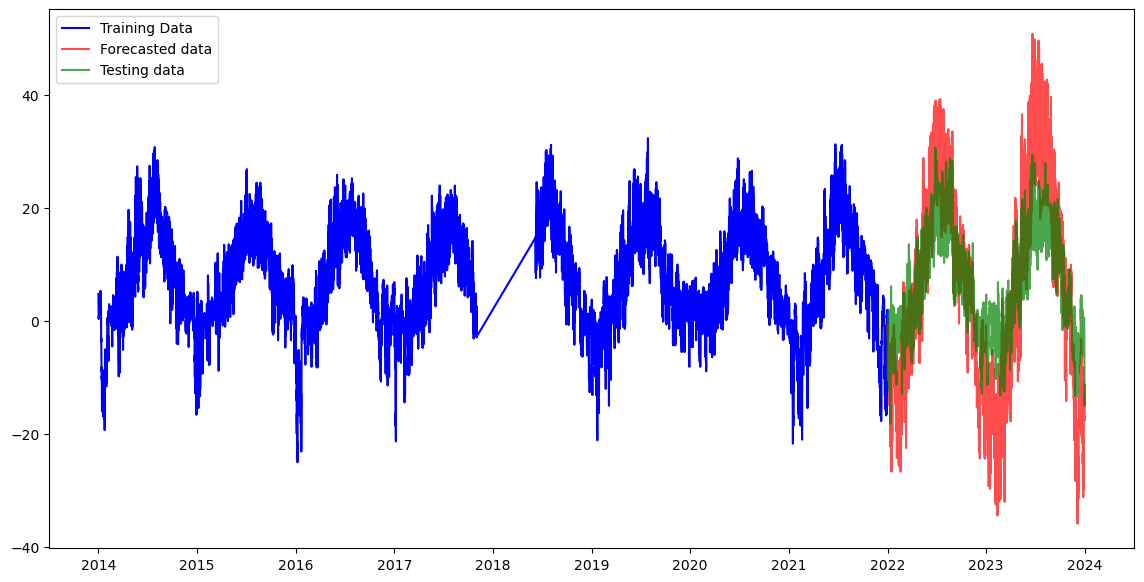

In [150]:
# Concatenate the forecast to the training dataframe
df_combined = pd.concat([df_train, final_forecast.rename('y')])

# Plotting the time series and the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['y'], color='blue', label='Training Data')
plt.plot(seasonally_adjusted_forecast.index, seasonally_adjusted_forecast, color='red', label='Forecasted data', alpha=0.7)
plt.plot(df_test.index, df_test['y'], color='green', label="Testing data", alpha=0.7)
plt.legend()
plt.show()

8. **Discussion:**: Discuss the performance of your chosen baseline model. Reflect on its strengths and limitations in capturing the underlying patterns of the data.

The MAE of 8.014 and RMSE of 10.29 suggest that while the model has some predictive power, it may struggle with the variability inherent in the temperature data. The model strength lies in modelling the seasonality trend, but its limitations cannot capture the underlying magnitude of the average temperature.

## **Exercise 5.4: Advanced time series forecasting with Prophet** (4 pt)

In the previous exercise, you used a baseline model to forecast temperatures based on temporal features.  In this exercise you will use [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) to forecast time series for the same period as in the previous exercise. Prophet is designed to handle time series data, making it well-suited for predicting temperature changes with higher accuracy. The goal is to capture hourly, daily and seasonal temperature variations more accurately, accounting for trends and any cyclical behavior observed in the temperature data.

1. Ensure your temperature dataset is formatted correctly for use with Prophet, with columns named `ds` (datetime format) and `y` (temperature).
2. Use the same split between training and testing data as in the previous exercise to ensure consistency in comparison.
3. Implement the Prophet model.
4. Evaluate the Prophet model with the same evaluation metrics as in the previous exercise.
5. Use Prophet's built-in plotting functions to visualize the forecast and its components (trend, seasonality, etc.).
6. Discuss the differences in the approach between your baseline model and the Prophet model. What are the consequences of these differences on forecast accuracy?

1. Ensure your temperature dataset is formatted correctly for use with Prophet, with columns named `ds` (datetime format) and `y` (temperature).

In [153]:
file_path = '/coursedata/users/nguyenb5/assignment5/Helsinki Kumpula 1.1.2014 - 31.12.2023.csv'
df = pd.read_csv(file_path)

df['timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg(' '.join, axis=1), 
                                 format='%Y %m %d %H:%M')

# Set 'timestamp' as the index and keep 'Average temperature [°C]' as the 'y' column
df = df.set_index('timestamp')[['Average temperature [°C]']].rename(columns={'Average temperature [°C]': 'y'})
df.index = pd.DatetimeIndex(df.index)
full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df[~df.index.duplicated(keep='first')]
df_complete = df.reindex(full_time_index)
df_inter = df_complete.interpolate(method='linear')

df_inter.head()

y
2014-01-01 00:00:00  4.4
2014-01-01 01:00:00  4.5
2014-01-01 02:00:00  4.8
2014-01-01 03:00:00  4.8
2014-01-01 04:00:00  4.7

In [154]:
df_inter = df_inter.reset_index()
df_inter.rename(columns={'index': 'ds', 'y': 'y'}, inplace=True)

df_inter.head()

ds    y
0 2014-01-01 00:00:00  4.4
1 2014-01-01 01:00:00  4.5
2 2014-01-01 02:00:00  4.8
3 2014-01-01 03:00:00  4.8
4 2014-01-01 04:00:00  4.7

2. Use the same split between training and testing data as in the previous exercise to ensure consistency in comparison.

In [157]:
df_features = df_inter.copy()
df_features["ds"] = pd.to_datetime(df_features["ds"])

# Split into training and test sets
df_train = df_features[df_features["ds"].dt.year <= (df_features["ds"].dt.year.max() - 2)]
df_test = df_features[df_features["ds"].dt.year > (df_features["ds"].dt.year.max() - 2)]

print("Number of datapoints in df_train", len(df_train))
print("Number of datapoints in df_test", len(df_test))

Number of datapoints in df_train 70128
Number of datapoints in df_test 17520


3. Implement the Prophet model.

In [95]:
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 33.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 58.0 MB/s eta 0:00:00


In [160]:
from prophet import Prophet

model = Prophet()
model.fit(df_train[['ds', 'y']])

future_dates = model.make_future_dataframe(periods=len(df_test), freq='H')
forecast = model.predict(future_dates)

# Display the first few predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


20:19:18 - cmdstanpy - INFO - Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
0 2014-01-01 00:00:00 -3.555308   -8.328967    1.192960
1 2014-01-01 01:00:00 -3.788971   -8.510572    1.249691
2 2014-01-01 02:00:00 -3.990256   -8.971686    0.828881
3 2014-01-01 03:00:00 -4.190454   -9.160497    0.459642
4 2014-01-01 04:00:00 -4.387854   -9.314149    0.331725

4. Evaluate the Prophet model with the same evaluation metrics as in the previous exercise.

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_test_pred = df_test.copy()
df_test_pred = model.predict(df_test_pred)

rmse = mean_squared_error(df_test['y'], df_test_pred['yhat'], squared=False)
mae = mean_absolute_error(df_test['y'], df_test_pred['yhat'])

print(f"MAE of forecasted temperature: {round(mae, 3)}")
print(f"RMSE of forecasted temperature: {round(rmse, 3)}")

MAE of forecasted temperature: 3.431
RMSE of forecasted temperature: 4.308


5. Use Prophet's built-in plotting functions to visualize the forecast and its components (trend, seasonality, etc.).

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

In [97]:
!pip install plotly==4.0
!pip install notebook==4.0.1
!pip install ipywidgets

Due to some unknown reasons, the plots are not compatible with this server, so I downloaded my code to my local desktop, and reuploading the figures in png format so that it can probably display the images. 

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

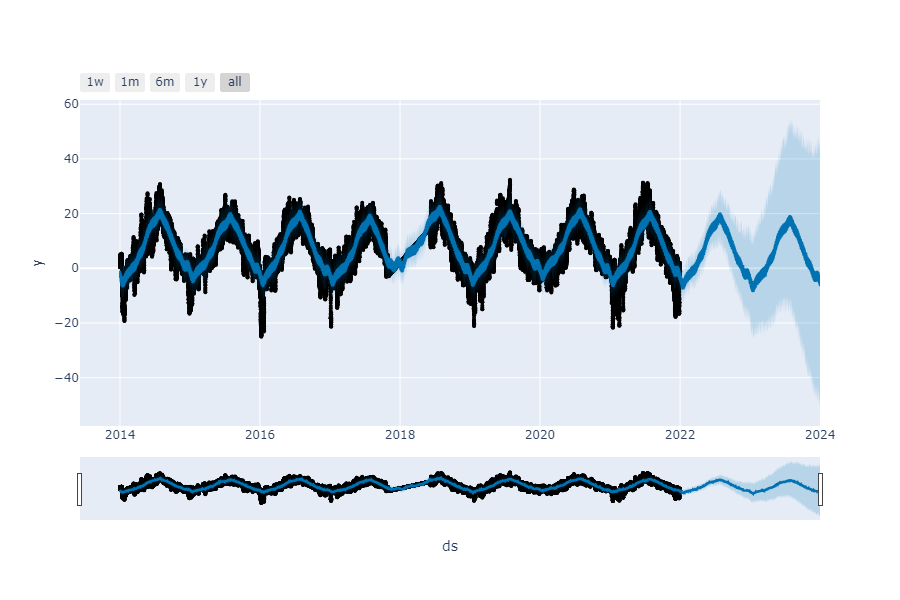

In [172]:
from IPython.display import Image

Image(filename="prophet_plot_forecast.png")

We can see the prediction by Facebook Prophet is immensely powerful, capturing the pattern exactly for the mean temperature. For the uncertainty (std), it starts to grow larger by 2023-2024, suggesting quantified uncertainty by the prediction model

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(model, forecast)

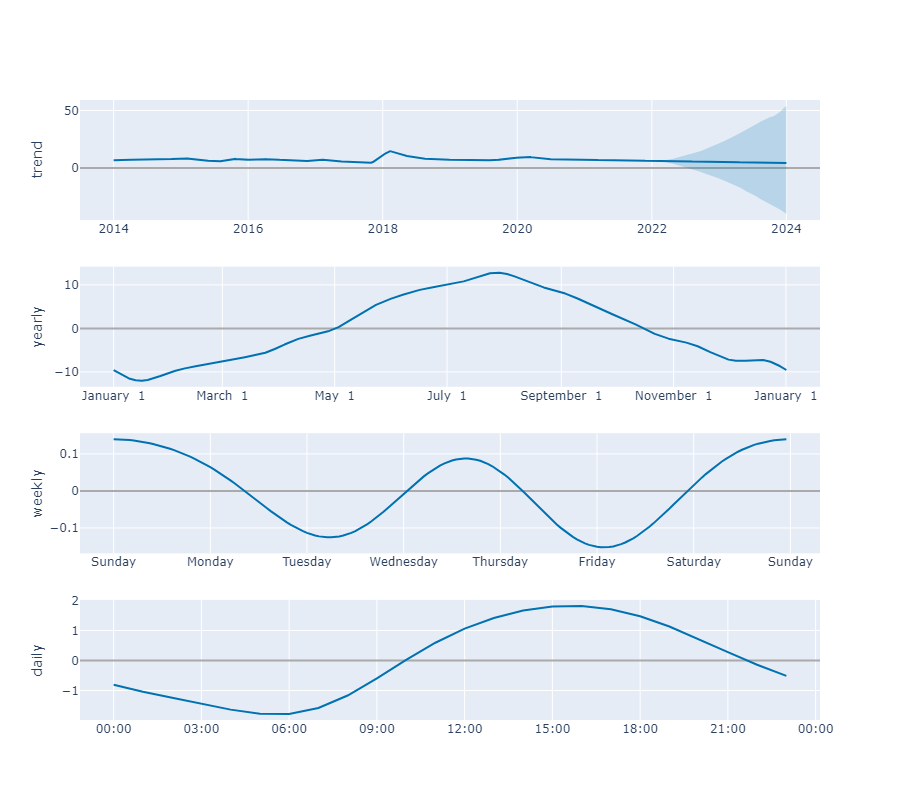

In [173]:
from IPython.display import Image

Image(filename="prophet_plot_components.png")

Analysis of the components graph:
    
1. Trend: There is no noticeable trend at all in temperature, suggesting that global warming is at least not clear in Finland
2. Yearly: It becomes coldest in the winter and hottest in the summer, as we have expected.
3. Weekly: It is harder to quantify but middle of the week and weekend tends to be hotter.
4. Daily: It becomes coldest in late midnight until early morning and becomes hottest during the noon-afternoon, as we have expected

6. Discuss the differences in the approach between your baseline model and the Prophet model. What are the consequences of these differences on forecast accuracy?

The baseline model you used earlier and the Prophet model have different approaches to forecasting time series data as follows:

1. Baseline models are typically simpler, using straightforward methods like MA and AR. These models rely heavily on the assumption that future data will follow past patterns. In contrast, Prophet uses a decomposable time series model with three main components: trend, seasonality, and holidays.

2. Baseline models require manual preprocessing of data to handle trends and seasonal effects. Prophet has built-in features to handle these automatically, and it is also robust to missing data and outliers, which must be preprocessed if we use the baseline model

3. Forecasting horizon: Baseline models might be more accurate for short-term forecasts. Prophet can be more accurate for long-term forecasts. This is observed from the clearly lower RMSE and MAE of Prophet model compared to the baseline model

Consequences on forecast accuracy:

- Baseline model might lead to less accuracy. However, for very stable time series, the baseline model might perform adequately and more efficiently (less computational exhausting)

- Prophet model is always likely to have higher forecast accuracy if there are complex seasonality, linear trends, varying variance and also holiday effects. However, training Prophet model can use more computational resources.

## **Exercise 5.5: Can you see the urban heat island effect?** (2 pt)

In urban areas, surfaces like roads and buildings absorb and retain heat more than natural landscapes, leading to higher temperatures compared to surrounding rural areas. This phenomenon is known as the Urban Heat Island (UHI) effect, and it is most noticeable during the night. In this exercise, you will investigate the UHI effect by comparing temperature data from two weather stations: one located within a city and another in a less urbanized area nearby.

1. **Data selection:** Choose a second weather station that is close to your initially selected station but located in a more rural area or further away from the city center. Ensure that both stations have temperature data available for the same time period.
2. **Data preparation:** Extract night-time temperature data for both stations, focusing specifically on the hours that are considered night-time. Given Finland's extreme variation in night-time length across seasons, you need to adjust the analysis for these variations. You will analyse summer and winter months separatly.
   - **Summer analysis:** During summer months (June, July, August), night-time is very short or non-existent. Consider using the late evening hours (e.g., 10 PM to 2 AM) for analysis (you can adapt this), and justify your choices. This period can still reflect urban heat retention even during the shortest nights.
   - **Winter analysis:** In winter (December, January, February), when nights are long, choose a consistent night-time window that reflects the coldest part of the night (e.g., 12 AM to 5 AM), when the UHI effect might be more pronounced due to prolonged darkness.
3. **Data analysis:** Calculate the average night-time temperature for each day for both locations. Compare the daily average night-time temperatures between the two stations over a significant period to identify any consistent temperature differences.
4. **Visualization:** Visualize the temperature differences between the urban and rural (or less urbanized) stations over time. Highlight any patterns or anomalies observed in the data, particularly those that might indicate the presence of the UHI effect.
5. **Discussion:** Discuss your findings, focusing on whether the data supports the existence of the UHI effect in the selected location. Reflect on the potential factors contributing to the observed temperature differences, such as urban density, vegetation cover, or proximity to heat-generating sources.

**Remark:** Finland’s geographical position leads to significant variations in day length throughout the year, which can influence the UHI effect. In summer, the almost continuous daylight in many parts of Finland means urban areas may not cool down as much during the night, potentially exaggerating the UHI effect. In contrast, during the long winter nights, differences in temperature between urban and rural areas might be influenced by factors like snow cover and heating practices. Considering these seasonal variations is essential for accurately assessing the UHI effect in your analysis.

1. **Data selection:** Choose a second weather station that is close to your initially selected station but located in a more rural area or further away from the city center. Ensure that both stations have temperature data available for the same time period.

In [3]:
file_path = '/coursedata/users/nguyenb5/assignment5/Helsinki Kumpula 1.1.2014 - 31.12.2023.csv'
df_urban = pd.read_csv(file_path)

df_urban['timestamp'] = pd.to_datetime(df_urban[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg(' '.join, axis=1), 
                                 format='%Y %m %d %H:%M')

# Set 'timestamp' as the index and keep 'Average temperature [°C]' as the 'y' column
df_urban = df_urban.set_index('timestamp')[['Average temperature [°C]']].rename(columns={'Average temperature [°C]': 'y'})
df_urban.index = pd.DatetimeIndex(df_urban.index)
full_time_index = pd.date_range(start=df_urban.index.min(), end=df_urban.index.max(), freq='H')
df_urban = df_urban[~df_urban.index.duplicated(keep='first')]
df_urban_complete = df_urban.reindex(full_time_index)
df_urban_inter = df_urban_complete.interpolate(method='linear')

df_urban_inter.head()

y
2014-01-01 00:00:00  4.4
2014-01-01 01:00:00  4.5
2014-01-01 02:00:00  4.8
2014-01-01 03:00:00  4.8
2014-01-01 04:00:00  4.7

In [43]:
file_path = '/coursedata/users/nguyenb5/assignment5/Helsinki-Vantaa airport 1.1.2014 - 31.12.2023.csv'
df_remote = pd.read_csv(file_path)

df_remote['timestamp'] = pd.to_datetime(df_remote[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg(' '.join, axis=1), 
                                 format='%Y %m %d %H:%M')

# Set 'timestamp' as the index and keep 'Average temperature [°C]' as the 'y' column
df_remote = df_remote.set_index('timestamp')[['Average temperature [°C]']].rename(columns={'Average temperature [°C]': 'y'})
df_remote.index = pd.DatetimeIndex(df_remote.index)
full_time_index = pd.date_range(start=df_remote.index.min(), end=df_remote.index.max(), freq='H')
df_remote = df_remote[~df_remote.index.duplicated(keep='first')]
df_remote_complete = df_remote.reindex(full_time_index)
df_remote_inter = df_remote_complete.interpolate(method='linear')

df_remote_inter.head()

y
2014-01-01 00:00:00  4.9
2014-01-01 01:00:00  5.1
2014-01-01 02:00:00  5.0
2014-01-01 03:00:00  4.9
2014-01-01 04:00:00  4.7

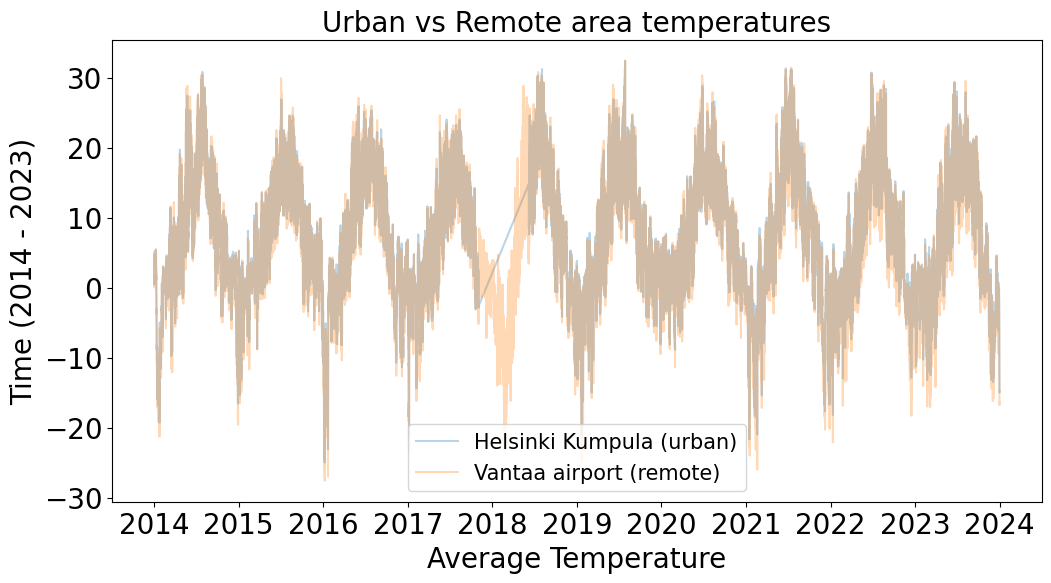

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(df_urban_inter.index, df_urban_inter['y'], label = "Helsinki Kumpula (urban)", alpha=0.3)
plt.plot(df_remote_inter.index, df_remote_inter['y'], label = "Vantaa airport (remote)", alpha=0.3)
plt.xlabel('Average Temperature',fontsize=20)
plt.ylabel('Time (2014 - 2023)',fontsize=20)
plt.title('Urban vs Remote area temperatures', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

2. **Data preparation:** Extract night-time temperature data for both stations, focusing specifically on the hours that are considered night-time. Given Finland's extreme variation in night-time length across seasons, you need to adjust the analysis for these variations. You will analyse summer and winter months separately.
   - **Summer analysis:** During summer months (June, July, August), night-time is very short or non-existent. Consider using the late evening hours (e.g., 10 PM to 2 AM) for analysis (you can adapt this), and justify your choices. This period can still reflect urban heat retention even during the shortest nights.
   - **Winter analysis:** In winter (December, January, February), when nights are long, choose a consistent night-time window that reflects the coldest part of the night (e.g., 12 AM to 5 AM), when the UHI effect might be more pronounced due to prolonged darkness.

### Summer analysis

In [38]:
summer_months = [6, 7, 8]

df_urban_summer_nights = df_urban_inter[df_urban_inter.index.month.isin(summer_months) & 
                                        (df_urban_inter.index.hour.isin(range(22, 24)) | 
                                        df_urban_inter.index.hour.isin(range(0, 2)))]

df_remote_summer_nights = df_remote_inter[df_remote_inter.index.month.isin(summer_months) & 
                                          (df_remote_inter.index.hour.isin(range(22, 24)) | 
                                          df_remote_inter.index.hour.isin(range(0, 2)))]

print("Urban area - summer nights")
print(df_urban_summer_nights.head())

print("\n\nRemote area - summer nights")
print(df_remote_summer_nights.head())

print("\n\nNumber of summer nights hours (start of 2014 - end of 2023)")
print(len(df_urban_summer_nights))
print(len(df_remote_summer_nights))

Urban area - summer nights
                        y
2014-06-01 00:00:00   9.2
2014-06-01 01:00:00   8.7
2014-06-01 22:00:00  13.7
2014-06-01 23:00:00  13.1
2014-06-02 00:00:00  12.7


Remote area - summer nights
                        y
2014-06-01 00:00:00   9.9
2014-06-01 01:00:00   9.0
2014-06-01 22:00:00  15.8
2014-06-01 23:00:00  14.1
2014-06-02 00:00:00  12.7


Number of summer nights hours (start of 2014 - end of 2023)
3680
3680


### Winter analysis

In [39]:
winter_months = [12, 1, 2]
df_urban_winter_nights = df_urban_inter[df_urban_inter.index.month.isin(winter_months) & 
                                        df_urban_inter.index.hour.isin(range(0, 5))]
df_remote_winter_nights = df_remote_inter[df_remote_inter.index.month.isin(winter_months) & 
                                          df_remote_inter.index.hour.isin(range(0, 5))]

print("Urban area - winter nights")
print(df_urban_winter_nights.head())

print("\n\nRemote area - winter nights")
print(df_remote_winter_nights.head())

print("\n\nNumber of winter nights hours (start of 2014 - end of 2023)")
print(len(df_urban_winter_nights))
print(len(df_remote_winter_nights))

Urban area - winter nights
                       y
2014-01-01 00:00:00  4.4
2014-01-01 01:00:00  4.5
2014-01-01 02:00:00  4.8
2014-01-01 03:00:00  4.8
2014-01-01 04:00:00  4.7


Remote area - winter nights
                       y
2014-01-01 00:00:00  4.9
2014-01-01 01:00:00  5.1
2014-01-01 02:00:00  5.0
2014-01-01 03:00:00  4.9
2014-01-01 04:00:00  4.7


Number of winter nights hours (start of 2014 - end of 2023)
4510
4510


3. **Data analysis:** Calculate the average night-time temperature for each day for both locations. Compare the daily average night-time temperatures between the two stations over a significant period to identify any consistent temperature differences.

In [45]:
# For urban area
df_urban_summer_nights_avg = df_urban_summer_nights.resample('D').mean()
df_urban_winter_nights_avg = df_urban_winter_nights.resample('D').mean()

# For remote area
df_remote_summer_nights_avg = df_remote_summer_nights.resample('D').mean()
df_remote_winter_nights_avg = df_remote_winter_nights.resample('D').mean()

# Merging the summer averages
df_summer_comparison = df_urban_summer_nights_avg.merge(df_remote_summer_nights_avg, left_index=True, right_index=True, suffixes=('_urban', '_remote'))
df_winter_comparison = df_urban_winter_nights_avg.merge(df_remote_winter_nights_avg, left_index=True, right_index=True, suffixes=('_urban', '_remote'))

df_summer_comparison['temp_diff_summer'] = df_summer_comparison['y_urban'] - df_summer_comparison['y_remote']
df_winter_comparison['temp_diff_winter'] = df_winter_comparison['y_urban'] - df_winter_comparison['y_remote']

print("Temperature difference in the summer")
print(df_summer_comparison.head())

print("\n\nTemperature difference in the winter")
print(df_winter_comparison.head())

Temperature difference in the summer
            y_urban  y_remote  temp_diff_summer
2014-06-01   11.175    12.200            -1.025
2014-06-02   14.350    13.950             0.400
2014-06-03   15.475    15.250             0.225
2014-06-04   17.800    18.475            -0.675
2014-06-05   18.400    19.550            -1.150


Temperature difference in the winter
            y_urban  y_remote  temp_diff_winter
2014-01-01     4.64      4.92             -0.28
2014-01-02     1.06      0.82              0.24
2014-01-03     1.06      0.58              0.48
2014-01-04     1.82      1.36              0.46
2014-01-05     4.68      4.28              0.40


In [46]:
# Calculating the number of days where urban has higher temperature than rural area and vice versa for Summer
urban_higher_summer = df_summer_comparison[df_summer_comparison['temp_diff_summer'] > 0].shape[0]
rural_higher_summer = df_summer_comparison[df_summer_comparison['temp_diff_summer'] < 0].shape[0]

# Calculating the same for Winter
urban_higher_winter = df_winter_comparison[df_winter_comparison['temp_diff_winter'] > 0].shape[0]
rural_higher_winter = df_winter_comparison[df_winter_comparison['temp_diff_winter'] < 0].shape[0]

print(f"(Summer night) urban area hotter than rural area: {urban_higher_summer} days")
print(f"(Summer night) urban area colder than rural area: {rural_higher_summer} days")
print(f"(Winter night) urban area hotter than rural area: {urban_higher_winter} days")
print(f"(Winter night) urban area colder than rural area: {rural_higher_winter} days")

(Summer night) urban area hotter than rural area: 551 days
(Summer night) urban area colder than rural area: 354 days
(Winter night) urban area hotter than rural area: 833 days
(Winter night) urban area colder than rural area: 66 days


From the diagnostics above, we already see that there is a clear UHI effect. 

4. **Visualization:** Visualize the temperature differences between the urban and rural (or less urbanized) stations over time. Highlight any patterns or anomalies observed in the data, particularly those that might indicate the presence of the UHI effect.

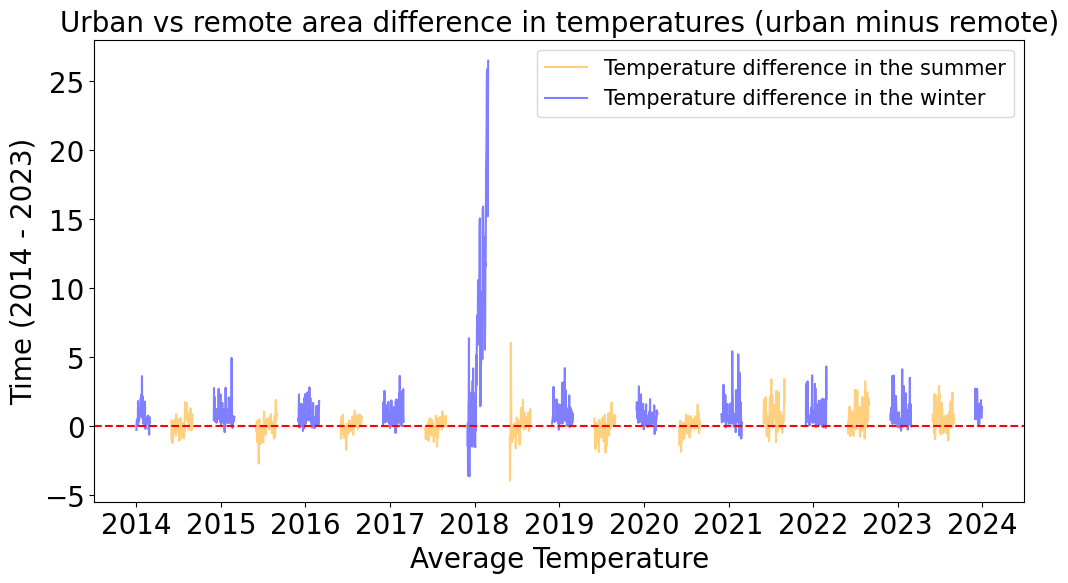

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(df_summer_comparison.index, df_summer_comparison['temp_diff_summer'], label = "Temperature difference in the summer", alpha=0.5, color = "orange")
plt.plot(df_winter_comparison.index, df_winter_comparison['temp_diff_winter'], label = "Temperature difference in the winter", alpha=0.5, color = "blue")
plt.xlabel('Average Temperature',fontsize=20)
plt.ylabel('Time (2014 - 2023)',fontsize=20)
plt.title('Urban vs remote area difference in temperatures (urban minus remote)', fontsize=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

Patterns or anomalies observed in the data, particularly those that might indicate the presence of the UHI effect: It is obvious from the plot that the difference in average temperature (urban temp minus remote temp) is more likely to be positive, suggesting clear presence of the UHI effect. However, it is clearer than in the summer, urban area is much more likely to be hotter than rural area compared to during the winter. 

Again, we can ignore the temperature difference in winter during 2018 due to missing data from Helsinki Kumpula area

5. **Discussion:** 

- Whether the data supports the existence of the UHI effect in the selected location: Yes, the data clearly support the UHI effect as observed in the positive temperature difference between Helsinki Kumpula (urban) and Ranua Airfield (remote). 

- Reflect on the potential factors contributing to the observed temperature differences:

Urban heat island effect: Urban areas like Helsinki, Espoo have much more buildings and other infrastructures that absorb heat better than rural areas. This leads to higher temperatures in urban areas, especially noticeable during night hours when the heat is still trapped in many offices.

Vegetation cover: areas with trees and grass, typical of remote locations, tend to have lower temperatures due to the shade provided by trees. The lack of grasses and trees in urban areas make temperatures hotter.

Closeness to heat sources: urban areas are often closer to human activities that generate significant amounts of heat like vehicles, air conditioners, and industrial machines. They all contribute to the UHI effect and result in higher temperatures in urban areas.


## **Exercise 5.6 (Optional): Enhancing your model with additional data** (4 pt)

Build on your previous forecasting models to refine your model's predictive performance by incorporating additional features. You can check [here](https://en.ilmatieteenlaitos.fi/download-observations) for more weather parameters.

Note that adding more variables to the model can increase its complexity, so it's important to justify the inclusion of each new feature based on its expected impact on model performance and its relevance to the forecasting objective.

I decided to add 2 more features, which are

1. Relative humidity, which directly affects evaporation and condensation in the atmosphere. Humidity changes heat retention properties of air and can change the formation of clouds, which can either trap heat or reflect sunlight.

2. Wind speed, which helps distribute heat across regions. Wind can bring warm or cold air into an areas. Moreover, wind speed influences evaporation rates, which can cool air surfaces.

In [86]:
file_path = '/coursedata/users/nguyenb5/assignment5/Helsinki Kumpula (additional features) 1.1.2014 - 31.12.2023.csv'
df = pd.read_csv(file_path, low_memory=False)

df['timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg(' '.join, axis=1), 
                                 format='%Y %m %d %H:%M')

# Set 'timestamp' as the index and keep 'Average temperature [°C]' as the 'y' column
df = df.set_index('timestamp')[['Average temperature [°C]', "Wind speed [m/s]", "Average relative humidity [%]"]].rename(
    columns={'Average temperature [°C]': 'y', "Wind speed [m/s]": "wind speed", "Average relative humidity [%]": "humidity"})

df.index = pd.DatetimeIndex(df.index)
full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df[~df.index.duplicated(keep='first')]
df_complete = df.reindex(full_time_index)
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['y'] = df['y'].interpolate(method='linear')
df['wind speed'] = pd.to_numeric(df['wind speed'], errors='coerce')
df['wind speed'] = df['wind speed'].interpolate(method='linear')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['humidity'] = df['humidity'].interpolate(method='linear')

df.head()

y  wind speed  humidity
timestamp                                     
2014-01-01 00:00:00  4.4         8.1      93.0
2014-01-01 01:00:00  4.5         8.4      91.0
2014-01-01 02:00:00  4.8         7.1      88.0
2014-01-01 03:00:00  4.8         7.4      86.0
2014-01-01 04:00:00  4.7         8.5      84.0

Now we can proceed to plot the 3 features against the hour timstamp for Helsinki Kumpula

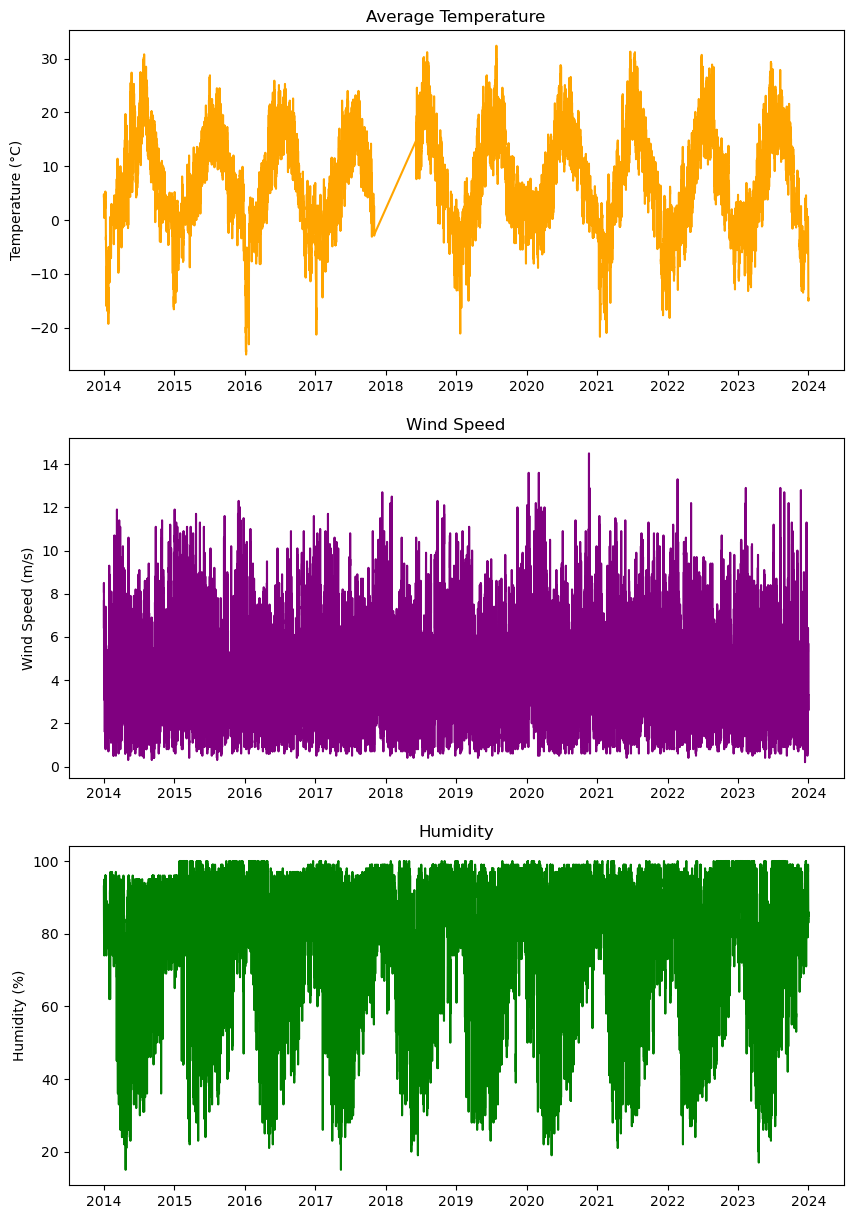

In [87]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

timestamps = pd.to_datetime(df.index)

axs[0].plot(timestamps, df["y"], color='orange')
axs[0].set_title('Average Temperature')
axs[0].set_ylabel('Temperature (°C)')

axs[1].plot(timestamps, df["wind speed"], color='purple')
axs[1].set_title('Wind Speed')
axs[1].set_ylabel('Wind Speed (m/s)')

axs[2].plot(timestamps, df["humidity"], color='green')
axs[2].set_title('Humidity')
axs[2].set_ylabel('Humidity (%)')

# plt.tight_layout()
plt.show()

We can see that the windspeed and humidity appear to have annual seasonality as well, suggesting they are good features in predicting the average temperature

In fact, the "feels like" temperature in weather report relies on environmental data including the ambient air temperature, relative humidity, and wind speed to determine how weather conditions feel to bare skin.

To save time, we can directly use Facebook Prophet for this task, which has already been shown that it performs better than our baseline model

In [93]:
df_inter = df.reset_index()
df_inter.rename(columns={'timestamp': 'ds'}, inplace=True)

df_inter.head()

ds    y  wind speed  humidity
0 2014-01-01 00:00:00  4.4         8.1      93.0
1 2014-01-01 01:00:00  4.5         8.4      91.0
2 2014-01-01 02:00:00  4.8         7.1      88.0
3 2014-01-01 03:00:00  4.8         7.4      86.0
4 2014-01-01 04:00:00  4.7         8.5      84.0

2. Use the same split between training and testing data as in the previous exercise to ensure consistency in comparison.

In [111]:
df_features = df_inter.copy()
df_features["ds"] = pd.to_datetime(df_features["ds"])

df_train = df_features[df_features["ds"].dt.year <= (df_features["ds"].dt.year.max() - 2)]
df_test = df_features[df_features["ds"].dt.year > (df_features["ds"].dt.year.max() - 2)]

# df_features_series = pd.Series(df_features["humidity"])

if df_features.isnull().values.any():
    print("The features contains NaN values.")
else:
    print("The features does not contain NaN values.")
    
print("Number of datapoints in df_train", len(df_train))
print("Number of datapoints in df_test", len(df_test))

The features does not contain NaN values.
Number of datapoints in df_train 70048
Number of datapoints in df_test 17470


In [103]:
from prophet import Prophet

model = Prophet()

model.add_regressor('wind speed')
model.add_regressor('humidity')

model.fit(df_train)

12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
future_dates = model.make_future_dataframe(periods=len(df_test), freq='H')
future_dates = future_dates.merge(df_test[['ds', 'wind speed', 'humidity']], on='ds', how='right')

forecast = model.predict(future_dates)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 2022-01-01 00:00:00 -5.237611  -10.178200   -0.207446
1 2022-01-01 01:00:00 -5.468949  -10.260430   -0.739689
2 2022-01-01 02:00:00 -5.715466  -10.155461   -0.809868
3 2022-01-01 03:00:00 -5.917340  -10.801787   -1.637126
4 2022-01-01 04:00:00 -5.929260  -10.759094   -0.904144

4. Evaluate the Prophet model with the same evaluation metrics as in the previous exercise.

In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(df_test['y'], forecast['yhat'], squared=False)
mae = mean_absolute_error(df_test['y'], forecast['yhat'])

print(f"MAE of forecasted temperature: {round(mae, 3)}")
print(f"RMSE of forecasted temperature: {round(rmse, 3)}")

MAE of forecasted temperature: 3.435
RMSE of forecasted temperature: 4.285


The results show that the predictive performance of Prophet did not change at all even when we add humidity and wind speed. The MAE and RMSE is roughly equal to those produced in the single time series regression on average temperature in part 5.3 previously.

The relationships between temperature and the added features wind speed and humidity may not be linear or they might have complex interactions not explainable by the model. For future actions, we can test out use only windspeed, only humidity, or use another feature to test whether it improves the accuracy of Prophet model. 